ALGOTHON INVESTIGATION

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
prices = pd.read_csv('prices.txt', delim_whitespace=True, header=None)
plt.figure(figsize=(15, 8))

C:\Users\Ben\AppData\Local\Temp\ipykernel_27572\2755470442.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prices = pd.read_csv('prices.txt', delim_whitespace=True, header=None)


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [3]:
returns = prices.pct_change().dropna()
print(returns.describe())
print(returns.skew())
print(returns.kurt())


               0           1           2           3           4           5   \
count  749.000000  749.000000  749.000000  749.000000  749.000000  749.000000   
mean    -0.000062   -0.000397   -0.000396   -0.000057   -0.000583    0.000035   
std      0.004553    0.005883    0.012755    0.011460    0.006762    0.005641   
min     -0.014493   -0.019997   -0.036575   -0.041377   -0.019971   -0.016450   
25%     -0.003267   -0.004348   -0.009319   -0.007171   -0.005129   -0.003793   
50%      0.000000   -0.000500   -0.000419    0.000000   -0.000201   -0.000324   
75%      0.003241    0.003600    0.007942    0.007636    0.003922    0.003967   
max      0.012565    0.017341    0.046700    0.041309    0.018811    0.021925   

               6           7           8           9   ...          40  \
count  749.000000  749.000000  749.000000  749.000000  ...  749.000000   
mean    -0.000916    0.000145    0.000014   -0.000083  ...    0.000027   
std      0.011534    0.011115    0.013900    0.0

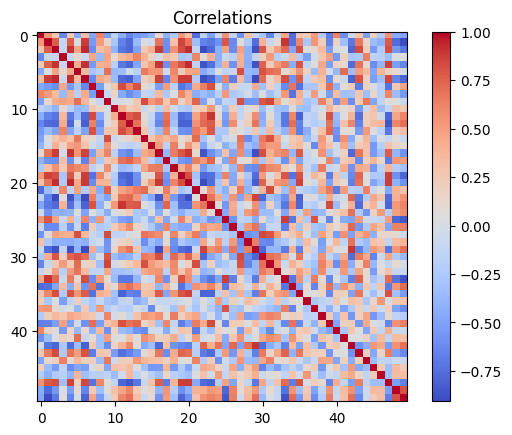

In [4]:
# Correlation heatmap between the assets
corr = prices.corr()
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.title('Correlations')
plt.show()

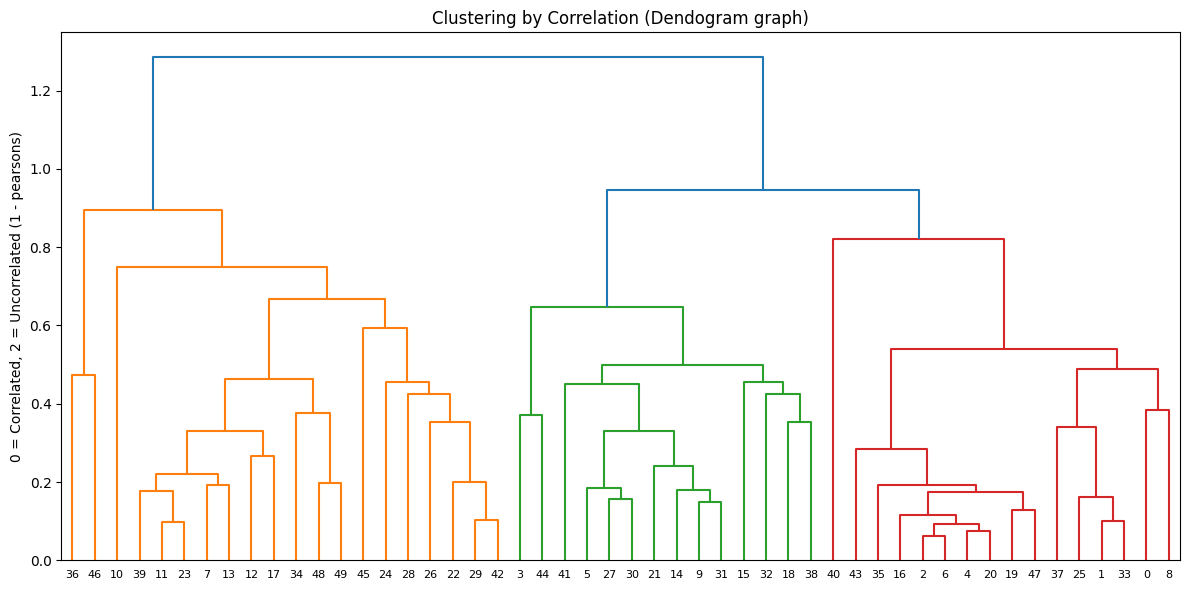

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

distance = 1 - corr

np.fill_diagonal(distance.values, 0)
condensed_dist = squareform(distance.values)
linkage_matrix = linkage(condensed_dist, method='average')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=corr.columns, leaf_rotation=0)
plt.title("Clustering by Correlation (Dendogram graph)")
plt.ylabel("0 = Correlated, 2 = Uncorrelated (1 - pearsons)")
plt.tight_layout()
plt.show()


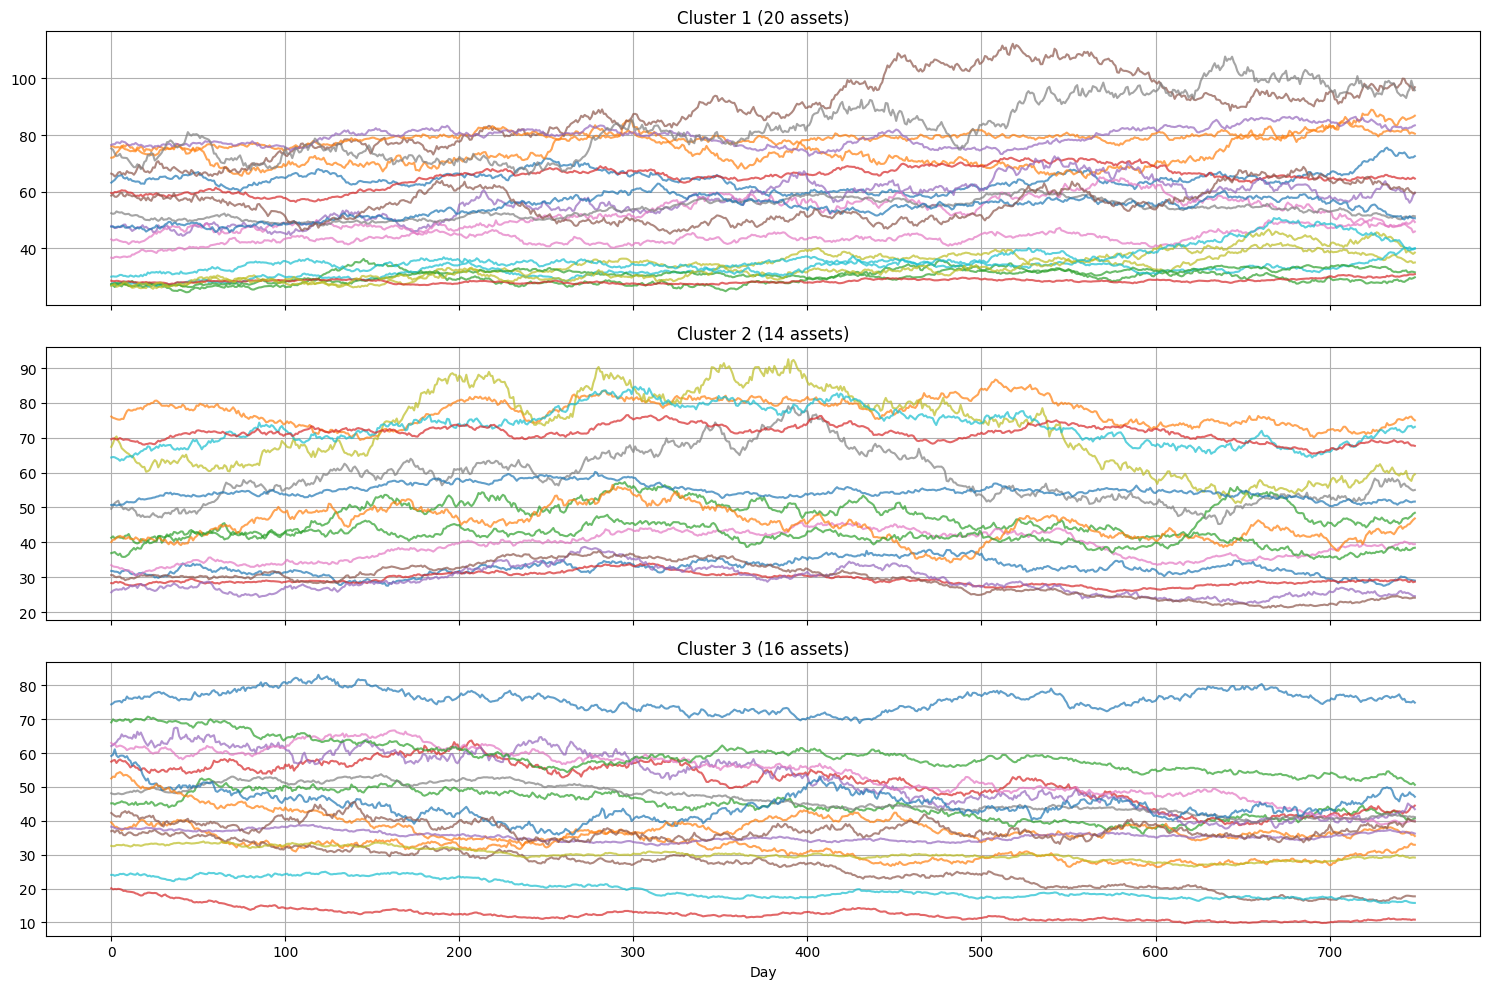

In [6]:
# Plotting clusters
C1 = [36,46,10,39,11,23,7,13,12,17,34,48,49,45,24,28,26,22,29,42]
C2 = [3,44,41,5,27,30,21,14,9,31,15,32,18,38]
C3 = [40,43,35,16,2,6,4,20,19,47,37,25,1,33,0,8]

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for i, C in enumerate([C1, C2, C3]):
    ax = axes[i]
    for c in C:
        ax.plot(prices.index, prices.iloc[:, c], alpha=0.7)
    ax.set_title(f"Cluster {i+1} ({len(C)} assets)")
    ax.grid(True)

plt.xlabel("Day")
plt.tight_layout()
plt.show()

9.488872945456231e-05
9.789015638387644e-05
9.591241829804629e-05


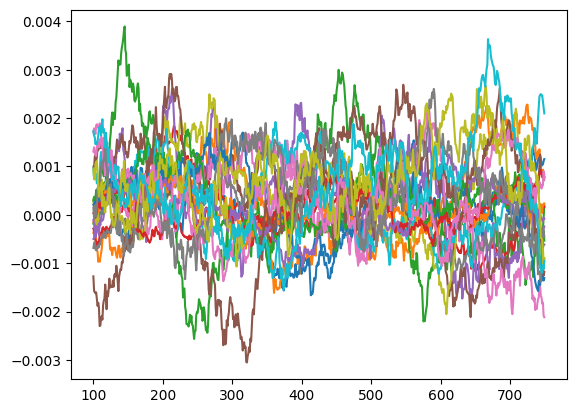

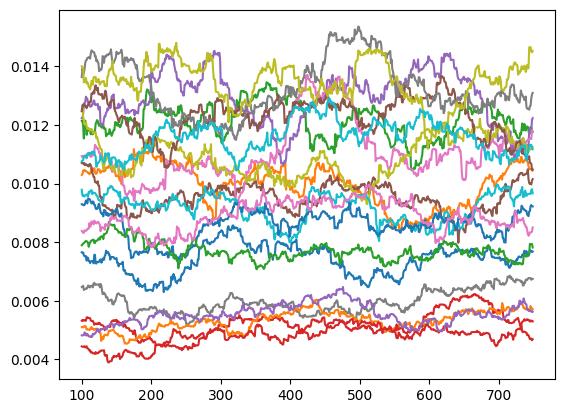

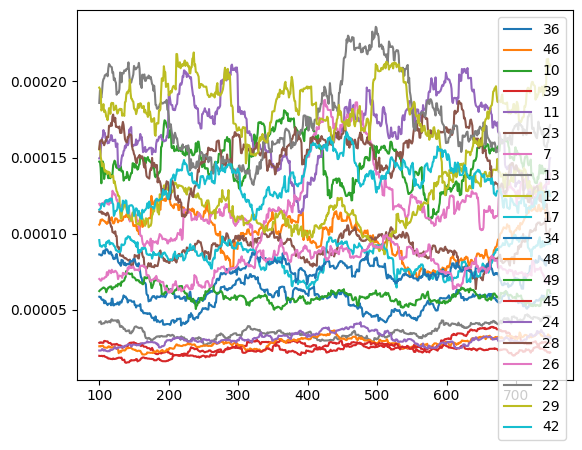

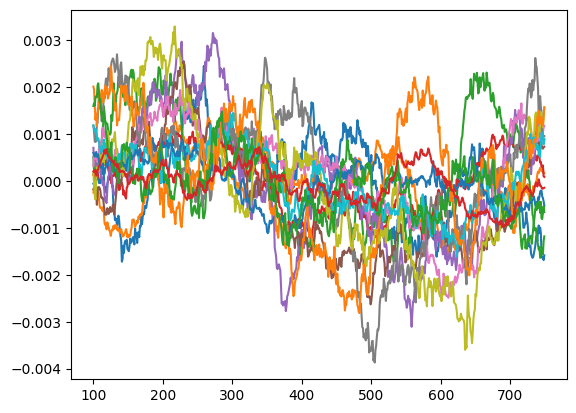

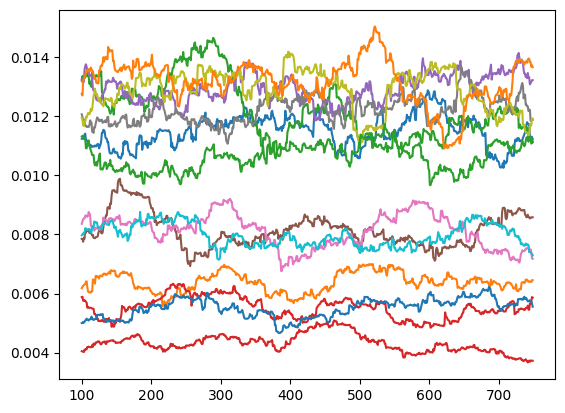

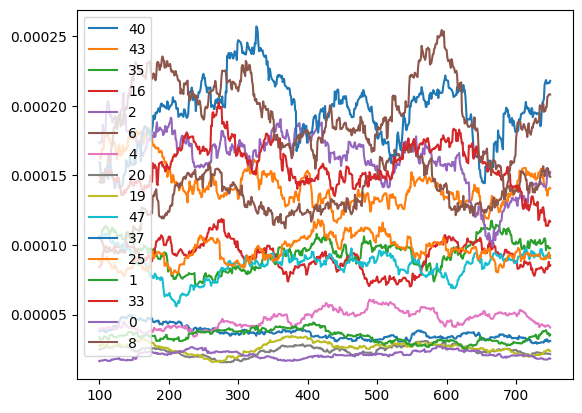

In [7]:
for C in [C1,C2,C3]:
    returns[C].rolling(100).mean().plot(legend=False)
    returns[C].rolling(100).std().plot(legend=False)
    returns[C].rolling(100).var().plot(legend=True)
    print(returns[C].var().mean())

Very interesting, I didn't expect to find anything but there appears to be 2 different clusters of variation within each correlation cluster

In [8]:
### Clusters seperated into high/low variance:
C1_Low = [13,45,24,39,48,36,49,46,23,17,34,26]
C1_High = [10,22,29,11,28,7,12,42]
C2_Low = [31,30,21,38,44,5,15]
C2_High = [3,18,14,27,32,41,9]
C3_High = [35,47,16,25,37,8,6,33,43,2]
C3_Low = [0,20,19,4,40,1]
C_Highs = [C1_High, C2_High, C3_High]
C_Lows = [C1_Low, C2_Low, C3_Low]


returns = prices.pct_change()  # assuming this is already defined

print("High-vol clusters:")
for i, C in enumerate(C_Highs, 1):
    mean_vol = returns[C].std().mean()
    print(f"Cluster {i} High: {mean_vol:.4f}")

print("\nLow-vol clusters:")
for i, C in enumerate(C_Lows, 1):
    mean_vol = returns[C].std().mean()
    print(f"Cluster {i} Low: {mean_vol:.4f}")

plt.figure(figsize=(12, 6))

days = 10
# Plot average rolling volatility (100-day) for each high-vol cluster
for i, C in enumerate(C_Highs, 1):
    avg_rolling_vol = returns[C].rolling(days).std().mean(axis=1)
    plt.plot(avg_rolling_vol, label=f'C{i} High Vol')

# Plot average rolling volatility (100-day) for each low-vol cluster
for i, C in enumerate(C_Lows, 1):
    avg_rolling_vol = returns[C].rolling(days).std().mean(axis=1)
    plt.plot(avg_rolling_vol, linestyle='--', label=f'C{i} Low Vol')

plt.title(f"Rolling {days}-day Average Volatility of High vs. Low Vol Clusters")
plt.xlabel("Day")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

High-vol clusters:
Cluster 1 High: 0.0122
Cluster 2 High: 0.0122
Cluster 3 High: 0.0115

Low-vol clusters:
Cluster 1 Low: 0.0074
Cluster 2 Low: 0.0066
Cluster 3 Low: 0.0055


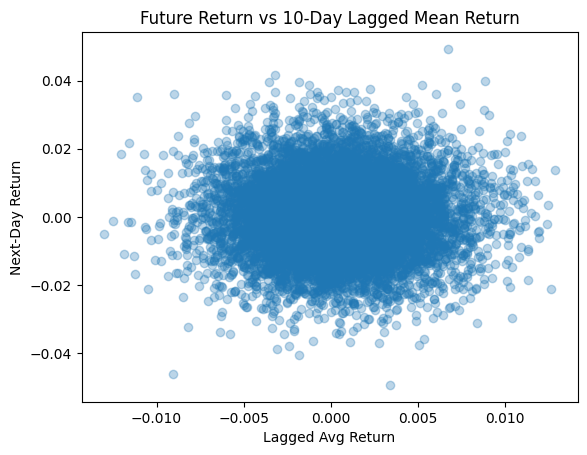

In [9]:
# Surface level check for lead/lag relationships (nothing obvious found)
lookback = 10
for C in [C1,C2,C3]:
    lagged = returns[C].rolling(lookback).mean().shift(1)
    future = returns[C].shift(-1)
    
    plt.scatter(lagged.values.flatten(), future.values.flatten(), alpha=0.3)
    plt.title(f"Future Return vs {lookback}-Day Lagged Mean Return")
    plt.xlabel("Lagged Avg Return")
    plt.ylabel("Next-Day Return")
    plt.show()


# Strategy Im gonna try:
- We ought maximise (PnL - 0.1*std(PnL))
- Subject to 5bps trading fee (=0.0005 * totalDollarVolumeTraded)
- Subject to position caps ($10k position limit per stock, positive or negative - any value gained over from stock increase is auto sold)

Potential High Volatility Cluster Strategies:
-Momentum
-Volatility bollinger bands breakout

Potential Low Volatility Cluster Strategies:
- StatArb: Pair trading, PCA
- Cluster-mean reversion


In [10]:
# Investigation into whether variance moving average crossover exists lol
w = 30
plt.figure()
#ass = prices[2]/prices[2][0]
ass = prices[3]
avg = ass.rolling(window=w).std().rolling(w).mean()
up = ass.rolling(window=w).std().rolling(w).mean() + ass.rolling(window=w).std().rolling(window=int(w/10)).std()*1.5
down = ass.rolling(window=w).std().rolling(w).mean() - ass.rolling(window=w).std().rolling(window=int(w/10)).std()*1.5
slow = ass.rolling(window=int(w*2)).std().rolling(int(w*2)).mean()
fast = ass.rolling(window=int(w/2)).std().rolling(int(w/2)).mean()
#plt.plot(prices.index, up)
plt.plot(prices.index, avg)
#plt.plot(prices.index, down)
plt.plot(prices.index, fast, alpha=0.2)
plt.plot(prices.index, slow, alpha=0.2)
plt.plot(prices.index, (slow+fast)/2, alpha=0.3)
plt.show()
 
# might try test: pretend slow+fast/2 is fair value with each being a band, sell when above slow and buy when under fast
# could even assume there's some baseline underlying variance?

In [11]:
# Pair Trading:


# pair function, take 2 assets
# calculate average as Asset 1 - Asset 2
'''When spread is higher than the mean, it implies that:
Stock 1 is overvalued → Good to sell/short
Stock 2 is undervalued → Good to buy/long
Overall, we would take a short position on the pairs trade
When spread is lower than the mean, it implies that:
Stock 1 is undervalued→ Good to buy/long
Stock 2 is overvalued→ Good to sell/short
Overall, we would take a long position on the pairs trade'''


'When spread is higher than the mean, it implies that:\nStock 1 is overvalued → Good to sell/short\nStock 2 is undervalued → Good to buy/long\nOverall, we would take a short position on the pairs trade\nWhen spread is lower than the mean, it implies that:\nStock 1 is undervalued→ Good to buy/long\nStock 2 is overvalued→ Good to sell/short\nOverall, we would take a long position on the pairs trade'

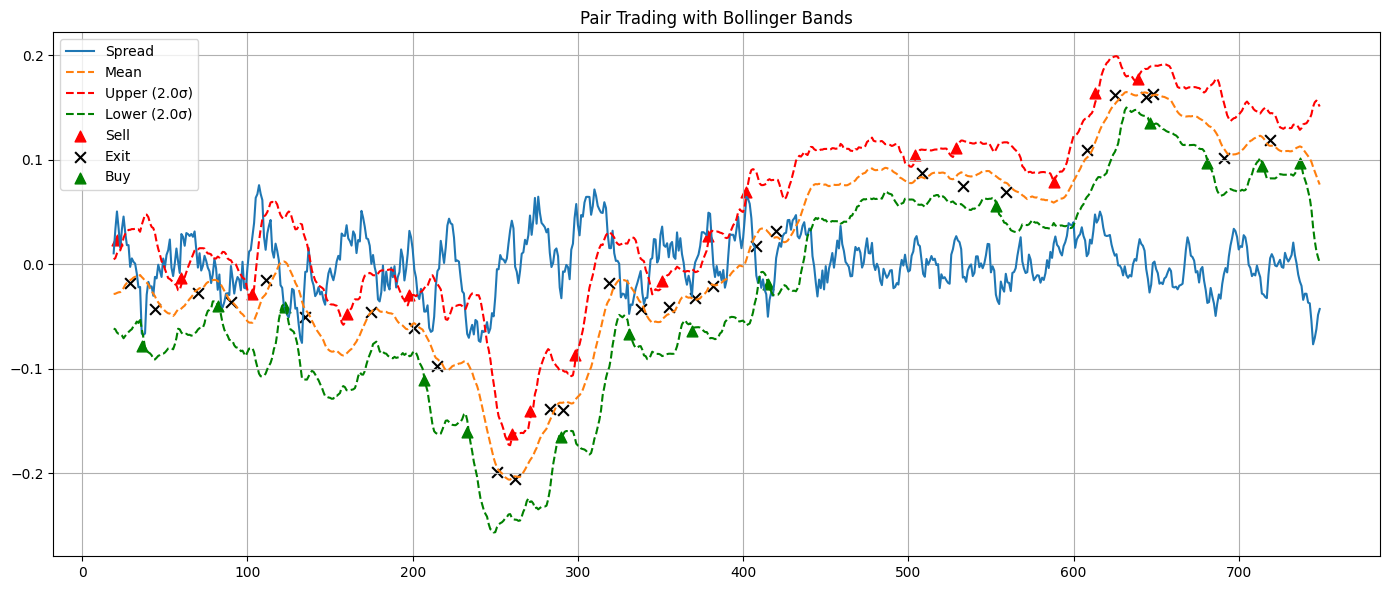

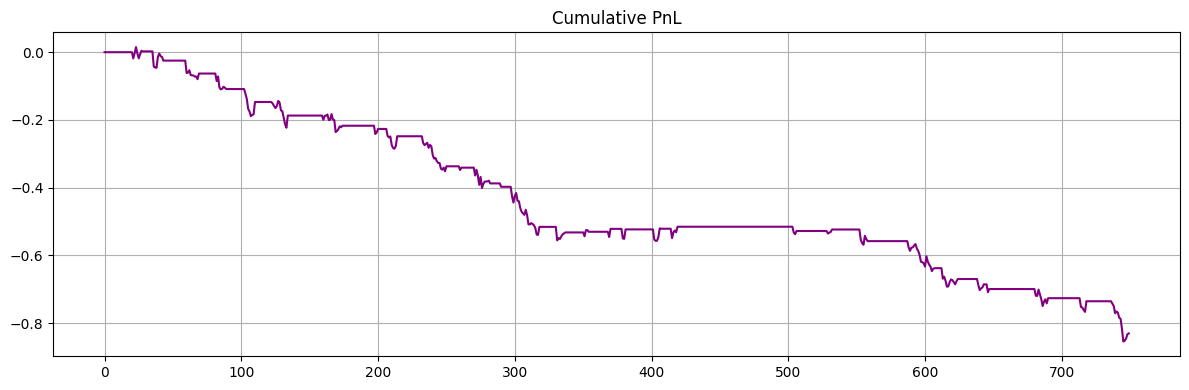

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
745   -0.038119
746    0.002379
747    0.006236
748    0.012875
749    0.002659
Length: 750, dtype: float64

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
# Attempt 1 at pair trading
def pair_trade_bollinger(prices1, prices2, lookback=20, entry_k=2.0, exit_k=0.5):
    # Normalize prices
    norm1 = prices1 / prices1.iloc[0]
    norm2 = prices2 / prices2.iloc[0]
    spread = norm1 - norm2

    mean = spread.rolling(lookback).mean()
    std = spread.rolling(lookback).std()

    upper = mean + entry_k * std
    lower = mean - entry_k * std
    exit_upper = mean + exit_k * std
    exit_lower = mean - exit_k * std

    # Initialize
    position = 0  # +1 long spread, -1 short spread
    pnl = []
    signals = []

    ret1 = prices1.pct_change()
    ret2 = prices2.pct_change()

    for t in range(lookback, len(spread)):
        s = spread.iloc[t]
        m = mean.iloc[t]
        u = upper.iloc[t]
        l = lower.iloc[t]
        eu = exit_upper.iloc[t]
        el = exit_lower.iloc[t]
        date = spread.index[t]

        # Entry logic
        if position == 0:
            if s < l:
                position = 1
                signals.append((date, s, 'Buy'))
            elif s > u:
                position = -1
                signals.append((date, s, 'Sell'))

        # Exit logic
        elif position == 1 and s > el:
            position = 0
            signals.append((date, s, 'Exit'))
        elif position == -1 and s < eu:
            position = 0
            signals.append((date, s, 'Exit'))

        # PnL
        daily_pnl = 0
        if position == 1:
            daily_pnl = ret1.iloc[t] - ret2.iloc[t]
        elif position == -1:
            daily_pnl = -ret1.iloc[t] + ret2.iloc[t]
        pnl.append(daily_pnl)

    pnl = [0]*lookback + pnl
    pnl = pd.Series(pnl, index=spread.index)

    # === Plot Spread with Bollinger Bands ===
    plt.figure(figsize=(14, 6))
    spread = spread - mean
    plt.plot(spread, label='Spread')
    plt.plot(mean, label='Mean', linestyle='--')
    plt.plot(upper, label=f'Upper ({entry_k}σ)', linestyle='--', color='red')
    plt.plot(lower, label=f'Lower ({entry_k}σ)', linestyle='--', color='green')

    for date, value, signal in signals:
        color = {'Buy': 'green', 'Sell': 'red', 'Exit': 'black'}[signal]
        marker = '^' if signal != 'Exit' else 'x'
        plt.scatter(date, value, color=color, marker=marker, s=60, label=signal)

    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys())
    plt.title("Pair Trading with Bollinger Bands")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Cumulative PnL ===
    pnl.cumsum().plot(title='Cumulative PnL', figsize=(12, 4), color='purple')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pnl

pair_trade_bollinger(prices[1],prices[2])

# Risk Management strategies to consider
- Position sizing (volatility scaling; ie inverse position sizing with volatility)
- Portfolio Diversification
- Stack signals in ML
- Stop losses

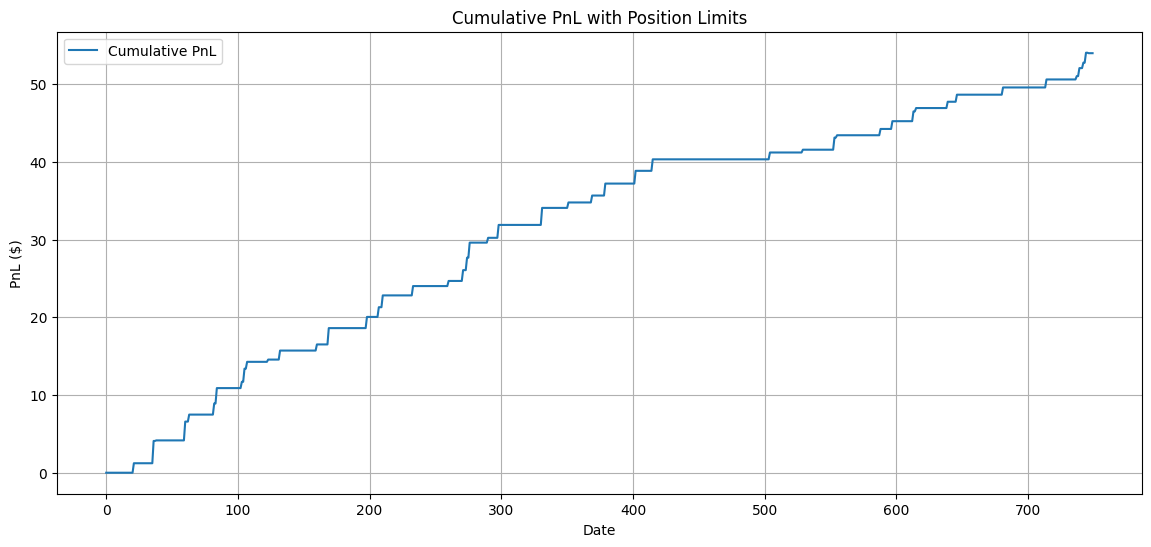

NameError: name 'plot_spread_bollinger' is not defined

In [13]:
def stat_arb_with_position_limits(prices1, prices2, lookback=20, entry_z=2, exit_z=0.5, max_dollar=10000, plot=True):
    norm1 = prices1 / prices1.iloc[0]
    norm2 = prices2 / prices2.iloc[0]

    spread = norm1 - norm2

    rolling_mean = spread.rolling(lookback).mean()
    rolling_std = spread.rolling(lookback).std()

    zscore = (spread - rolling_mean) / rolling_std

    position = 0
    pnl = []
    positions = []
    scaled_positions1 = []
    scaled_positions2 = []

    for t in range(len(spread)):
        if t < lookback:
            pnl.append(0)
            positions.append(0)
            scaled_positions1.append(0)
            scaled_positions2.append(0)
            continue

        # Entry/exit logic
        if position == 0:
            if zscore.iloc[t] > entry_z:
                position = 1
            elif zscore.iloc[t] < -entry_z:
                position = -1
        elif position == 1 and zscore.iloc[t] >= -exit_z:
            position = 0
        elif position == -1 and zscore.iloc[t] <= exit_z:
            position = 0

        positions.append(position)

        # Calculate max affordable units for each asset
        price1 = prices1.iloc[t]
        price2 = prices2.iloc[t]

        # Units for each asset without scaling
        # For long spread (position=1): long asset1, short asset2
        # For short spread (position=-1): short asset1, long asset2
        units1 = position  # +1 or -1 or 0
        units2 = -position

        # Dollar exposures
        dollar_exp_1 = abs(units1 * price1 * max_dollar)
        dollar_exp_2 = abs(units2 * price2 * max_dollar)

        # Scale factor to respect max dollar limit
        scale1 = max_dollar / (abs(units1 * price1) + 1e-8) if units1 != 0 else 0
        scale2 = max_dollar / (abs(units2 * price2) + 1e-8) if units2 != 0 else 0

        scale = min(scale1, scale2, 1)  # Ensure not exceeding limits, max scale=1 (no increase)

        scaled_units1 = units1 * scale
        scaled_units2 = units2 * scale

        scaled_positions1.append(scaled_units1)
        scaled_positions2.append(scaled_units2)

        # Calculate PnL for day t
        if t == 0:
            pnl.append(0)
        else:
            ret1 = prices1.iloc[t] - prices1.iloc[t - 1]
            ret2 = prices2.iloc[t] - prices2.iloc[t - 1]

            daily_pnl = scaled_units1 * ret1 + scaled_units2 * ret2
            pnl.append(daily_pnl)

    pnl = pd.Series(pnl, index=spread.index)
    positions = pd.Series(positions, index=spread.index)
    scaled_positions1 = pd.Series(scaled_positions1, index=spread.index)
    scaled_positions2 = pd.Series(scaled_positions2, index=spread.index)

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(pnl.cumsum(), label='Cumulative PnL')
        plt.title('Cumulative PnL with Position Limits')
        plt.xlabel('Date')
        plt.ylabel('PnL ($)')
        plt.grid(True)
        plt.legend()
        plt.show()
        plt.figure()
        plt.plot(positions)
        plt.show()
    return pnl, positions, scaled_positions1, scaled_positions2
stat_arb_with_position_limits(prices[1], prices[2])
plot_spread_bollinger(prices[1]-prices[2], window=20, num_std=2)

### Attempt at Fair Trading Strategy for each asset:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure prices are a NumPy array of shape (assets x days)
prices_array = prices.T.values  # Shape: (assets, days)

num_assets, num_days = prices_array.shape
commission_rate = 0.001
position_limit_dollars = 10000

def get_my_position(prices_window, window=20):
    current_prices = prices_window[:, -1]
    if prices_window.shape[1] < window:
        return np.zeros(prices_window.shape[0], dtype=int)
    
    fair_value = prices_window[:, -window:].mean(axis=1)
    mispricing = fair_value - current_prices

    # Normalize and scale
    raw_position = (mispricing / current_prices) * 1000
    capped_position = np.clip(raw_position, -position_limit_dollars / current_prices, position_limit_dollars / current_prices)

    return capped_position.astype(int)

# Initialize
position = np.zeros(num_assets)
pnl = []
pnl_by_asset = np.zeros((num_days, num_assets))  # Track per-asset PnL

for t in range(num_days):
    current_window = prices_array[:, :t+1]
    new_position = get_my_position(current_window)

    price_today = prices_array[:, t]
    price_yesterday = prices_array[:, t - 1] if t > 0 else price_today

    # Clip positions to $10k per asset
    new_position = np.clip(new_position, -position_limit_dollars / price_today, position_limit_dollars / price_today).astype(int)

    trades = new_position - position
    traded_value = np.abs(trades * price_today)
    commission = traded_value * commission_rate

    # Calculate per-asset PnL
    daily_pnl_assets = (position * (price_today - price_yesterday)) - commission
    pnl_by_asset[t] = daily_pnl_assets
    pnl.append(daily_pnl_assets.sum())

    position = new_position

cumulative_pnl_by_asset = pnl_by_asset.cumsum(axis=0)

plt.figure(figsize=(14, 6))
for i in range(num_assets):
    plt.plot(cumulative_pnl_by_asset[:, i], alpha=0.5, label=f'Asset {i}')
plt.title("Cumulative PnL per Asset")
plt.xlabel("Day")
plt.ylabel("PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

total_pnl_per_asset = cumulative_pnl_by_asset[-1]
top_assets = total_pnl_per_asset.argsort()[-5:][::-1]
bottom_assets = total_pnl_per_asset.argsort()[:5]

plt.figure(figsize=(12, 5))
for i in top_assets:
    plt.plot(cumulative_pnl_by_asset[:, i], label=f'Top {i}')
for i in bottom_assets:
    plt.plot(cumulative_pnl_by_asset[:, i], label=f'Bottom {i}')
plt.title("Top & Bottom 5 Asset PnLs")
plt.legend()
plt.grid(True)
plt.show()

cumulative_pnl = pnl_by_asset.cumsum(axis=0).T  # shape: [assets, days]
plt.figure(figsize=(12, 6))
im = plt.imshow(-cumulative_pnl, aspect='auto', cmap='coolwarm', interpolation='none')
plt.colorbar(im, label='Cumulative PnL')
plt.title("PnL Heatmap (Assets × Time)")
plt.xlabel("Day")
plt.ylabel("Asset Index")
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def trade_spread_bollinger(prices1, prices2, window=20, num_std=2, plot=True):
    """
    Improved Bollinger Band pair trading strategy with correct PnL calculation.
    Assumes $10k long/short per side max, 0.1% commission per trade.
    """

    norm1 = prices1 / prices1.iloc[0]
    norm2 = prices2 / prices2.iloc[0]
    spread = norm1 - norm2

    rolling_mean = spread.rolling(window).mean()
    rolling_std = spread.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std

    position1 = 0
    position2 = 0
    positions = []
    cash = 0
    pnl = []
    signals = []
    commission_rate = 0.0005
    dollar_limit = 10000

    for t in range(window, len(spread)):
        s = spread.iloc[t]
        mu = rolling_mean.iloc[t]
        up = upper_band.iloc[t]
        low = lower_band.iloc[t]

        p1 = prices1.iloc[t]
        p2 = prices2.iloc[t]

        # Save previous prices for PnL
        p1_prev = prices1.iloc[t - 1]
        p2_prev = prices2.iloc[t - 1]

        # Determine new position
        if s <= low:
            # Long spread: Long asset1, Short asset2
            new_pos1 = int(dollar_limit / p1)
            new_pos2 = -int(dollar_limit / p2)
            signals.append((spread.index[t], s, 'Buy'))
        elif s >= up:
            # Short spread: Short asset1, Long asset2
            new_pos1 = -int(dollar_limit / p1)
            new_pos2 = int(dollar_limit / p2)
            signals.append((spread.index[t], s, 'Sell'))
        elif (s >= mu and position1 > 0) or (s <= mu and position1 < 0):
            # Exit condition: close positions
            new_pos1 = 0
            new_pos2 = 0
            signals.append((spread.index[t], s, 'Exit'))
        else:
            # Hold
            new_pos1 = position1
            new_pos2 = position2

        # Calculate trade volumes and commission
        trades1 = new_pos1 - position1
        trades2 = new_pos2 - position2
        traded_value = abs(trades1 * p1) + abs(trades2 * p2)
        commission = traded_value * commission_rate

        # Calculate PnL from price changes
        daily_pnl = position1 * (p1 - p1_prev) + position2 * (p2 - p2_prev) - commission
        pnl.append(daily_pnl)

        # Update positions
        position1 = new_pos1
        position2 = new_pos2

    # Align with full time index
    full_pnl = pd.Series([0] * window + pnl, index=prices1.index)
    score = full_pnl.mean() - 0.1 * full_pnl.std()

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(spread, label='Spread', color='blue')
        plt.plot(rolling_mean, '--', label='Mean', color='black')
        plt.plot(upper_band, '--', label=f'+{num_std}σ', color='red')
        plt.plot(lower_band, '--', label=f'-{num_std}σ', color='green')
        for date, value, signal in signals:
            marker = {'Buy': '^', 'Sell': 'v', 'Exit': 'x'}[signal]
            color = {'Buy': 'green', 'Sell': 'red', 'Exit': 'black'}[signal]
            plt.scatter(date, value, marker=marker, color=color, s=80, label=signal)
        plt.title('Spread and Signals')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        full_pnl.cumsum().plot(title='Cumulative PnL', figsize=(12, 4), color='purple')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(score)

    return full_pnl, score

trade_spread_bollinger(prices[22], prices[29], window=20, num_std=2, plot=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Core Strategy Function ---
def trade_spread_bollinger(prices1, prices2, window=20, num_std=2):
    """
    Pair trading using Bollinger Bands on spread.
    Returns full-length PnL Series and score.
    """
    # Normalize
    norm1 = prices1 / prices1.iloc[0]
    norm2 = prices2 / prices2.iloc[0]
    spread = norm1 - norm2

    mean = spread.rolling(window).mean()
    std = spread.rolling(window).std()

    upper = mean + num_std * std
    lower = mean - num_std * std

    position = 0  # 1=long spread, -1=short spread
    pnl = np.zeros(len(spread))
    transaction_count = np.zeros(len(spread))

    for t in range(1, len(spread)):
        if t < window:
            continue

        s = spread.iloc[t]
        mu = mean.iloc[t]
        up = upper.iloc[t]
        low = lower.iloc[t]

        # Entry
        if position == 0:
            if s <= low:
                position = 1
                transaction_count[t] += 1
            elif s >= up:
                position = -1
                transaction_count[t] += 1
        # Exit
        elif position == 1 and s >= mu:
            position = 0
        elif position == -1 and s <= mu:
            position = 0

        # PnL: $10k per side
        delta = spread.iloc[t] - spread.iloc[t - 1]
        if position == 1:
            pnl[t] = -delta * 10000
        elif position == -1:
            pnl[t] = delta * 10000

    # Commission: 0.0005 per trade (5bps per side)
    commission = transaction_count * 0.0005 * 2 * 10000
    pnl -= commission

    pnl_series = pd.Series(pnl, index=prices1.index)
    score = pnl_series.mean() - 0.1 * pnl_series.std()
    return pnl_series, score


# --- Load or simulate data ---
# Assuming `prices` is a (50 x 750) DataFrame (assets × days)
# Example: prices = pd.read_csv("prices.csv", index_col=0)

# Make sure your prices DataFrame has consistent index and shape
num_assets = prices.shape[0]
num_days = prices.shape[1]
asset_names = prices.index
date_index = prices.columns

# --- PnL Aggregation ---
pnl_by_asset = np.zeros((num_days, num_assets))

for i in range(num_assets):
    for j in range(i + 1, num_assets):
        pnl, _ = trade_spread_bollinger(prices.iloc[i], prices.iloc[j])

        # Align pnl to full date index
        pnl = pnl.reindex(date_index, fill_value=0)

        # Attribution: split between asset i and j
        pnl_by_asset[:, i] += pnl.values / 2
        pnl_by_asset[:, j] += pnl.values / 2


# --- Plotting ---

# Cumulative PnL by asset
cumulative_pnl_by_asset = pnl_by_asset.cumsum(axis=0)

# Line plot of cumulative PnL
plt.figure(figsize=(14, 6))
for i in range(num_assets):
    plt.plot(cumulative_pnl_by_asset[:, i], label=f'Asset {i}', alpha=0.5)
plt.title("Cumulative PnL per Asset (Bollinger Bands Strategy)")
plt.xlabel("Day")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(12, 6))
im = plt.imshow(cumulative_pnl_by_asset.T, aspect='auto', cmap='coolwarm', interpolation='none')
plt.colorbar(im, label='Cumulative PnL')
plt.title("PnL Heatmap (Assets × Time) - Bollinger Bands")
plt.xlabel("Day")
plt.ylabel("Asset Index")
plt.tight_layout()
plt.show()


In [ ]:
total_pnl = 0
best_score = 0
worst_score = 0
scores = []
for i in range(49):
    for j in range(50):
        if j > i:
            pnl, score = trade_spread_bollinger(prices[i], prices[j], window=20, num_std=2)
            #print(f"Score = {score:.2f}, Mean PnL = {pnl.mean():.2f}, StdDev = {pnl.std():.2f}")
            total_pnl += pnl
            if score > best_score:
                best_score = score
                print('best score:', score, 'at', i, j)
            if score < worst_score:
                worst_score = score
                print('worst score:', score, i, j)
            scores.append(score)
print("total pnl:", total_pnl)
plt.figure()
plt.title(f'pnl for every combination of the 50 assets being pair traded')
plt.plot(total_pnl)
plt.show()

In [ ]:
plt.figure()
plt.boxplot(scores)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt

# Parameters
windows = list(range(5, 61, 5))  # Test windows from 5 to 60 days
max_lag = 5  # Max lag to test for lead-lag relationship
threshold_score = 0  # Minimum score to consider strategy viable

# Store results
results = []

def compute_lead_lag_pnl(lead, lag, window, lag_shift):
    """
    Implements a simple lead-lag strategy:
    If lead asset's return is positive over past window -> long lag asset
    If lead asset's return is negative -> short lag asset
    """

    lead_ret = lead.pct_change(window).shift(lag_shift)
    lag_ret = lag.pct_change().shift(-1)  # Next-day return of lag asset

    signal = np.sign(lead_ret)
    pnl = signal * lag_ret

    # Drop NaNs
    pnl = pnl.dropna()

    score = pnl.mean() / pnl.std() if pnl.std() > 0 else -np.inf
    cumulative_pnl = pnl.cumsum()

    return pnl, score, cumulative_pnl

# Loop over all pairs
num_assets = prices.shape[0]
asset_pairs = list(combinations(range(num_assets), 2))

for i, j in asset_pairs:
    lead_series = prices.iloc[i]
    lag_series = prices.iloc[j]
    for window in windows:
        for lag_shift in range(1, max_lag + 1):
            pnl, score, _ = compute_lead_lag_pnl(lead_series, lag_series, window, lag_shift)
            if len(pnl) < 50:
                continue  # Avoid short series

            if score > threshold_score:
                results.append({
                    "lead": i,
                    "lag": j,
                    "window": window,
                    "lag_shift": lag_shift,
                    "score": score,
                    "mean_pnl": pnl.mean(),
                    "std_pnl": pnl.std(),
                    "sharpe": score,
                    "length": len(pnl)
                })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="score", ascending=False)

# Display top strategies
print("Top Lead-Lag Strategy Candidates:")
print(results_df.head(10))

# Plot top result
if not results_df.empty:
    top = results_df.iloc[0]
    pnl, _, cumulative_pnl = compute_lead_lag_pnl(
        prices.iloc[top['lead']], prices.iloc[top['lag']],
        int(top['window']), int(top['lag_shift'])
    )
    cumulative_pnl.plot(title=f"Cumulative PnL (Lead {top['lead']} → Lag {top['lag']}, window={top['window']}, lag={top['lag_shift']})", figsize=(10, 4))
    plt.grid(True)
    plt.xlabel("Day")
    plt.ylabel("Cumulative PnL")
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Settings
lookback_range = range(10, 101, 10)  # Try windows from 10 to 100
commission = 0.0005  # 5bps per trade
holding_period = 5   # Max holding period for simplicity
price_data = prices.copy()  # Assume 'prices' is [assets x days] DataFrame

# Output holders
best_pnls = []
best_windows = []
cumulative_pnls = []

# Donchian strategy function
def donchian_strategy(prices, lookback):
    position = 0
    entry_price = 0
    pnl = []
    days_in_trade = 0

    highs = prices.rolling(lookback).max()
    lows = prices.rolling(lookback).min()

    for t in range(1, len(prices)):
        price_today = prices.iloc[t]
        price_yesterday = prices.iloc[t - 1]
        high = highs.iloc[t - 1]
        low = lows.iloc[t - 1]

        # Entry signals
        if position == 0:
            if price_yesterday > high:
                position = 1
                entry_price = price_today
                days_in_trade = 0
                pnl.append(-commission * price_today)
            elif price_yesterday < low:
                position = -1
                entry_price = price_today
                days_in_trade = 0
                pnl.append(-commission * price_today)
            else:
                pnl.append(0)
        else:
            days_in_trade += 1
            exit = False

            # Exit signals: opposite breakout or holding period exceeded
            if (position == 1 and price_yesterday < low) or \
               (position == -1 and price_yesterday > high) or \
               days_in_trade >= holding_period:
                pnl.append((price_today - entry_price) * position - commission * price_today)
                position = 0
                entry_price = 0
            else:
                pnl.append((price_today - price_yesterday) * position)

    # Pad beginning
    pnl = [0] * (lookback - 1) + pnl
    return pd.Series(pnl, index=prices.index)

# Optimize for each asset
for asset_index in range(price_data.shape[0]):
    asset_prices = price_data.iloc[asset_index]
    best_score = -np.inf
    best_pnl = None
    best_window = None

    for lookback in lookback_range:
        pnl = donchian_strategy(asset_prices, lookback)
        if pnl.std() == 0:
            continue
        score = pnl.mean() / pnl.std()  # Sharpe-like
        if score > best_score:
            best_score = score
            best_pnl = pnl
            best_window = lookback

    best_pnls.append(best_pnl)
    best_windows.append(best_window)
    cumulative_pnls.append(best_pnl.cumsum())

    print(f"Asset {asset_index}: Best Lookback = {best_window}, Score = {best_score:.3f}")

# === Plot each asset's cumulative PnL ===
plt.figure(figsize=(14, 6))
for i, pnl in enumerate(cumulative_pnls):
    plt.plot(pnl, label=f'Asset {i} (win={best_windows[i]})', alpha=0.5)
plt.title("Cumulative PnL per Asset with Optimized Donchian Parameters")
plt.xlabel("Day")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Heatmap view ===
plt.figure(figsize=(12, 6))
heatmap_data = np.array([p.values for p in cumulative_pnls])
plt.imshow(heatmap_data, aspect='auto', cmap='coolwarm', interpolation='none')
plt.colorbar(label='Cumulative PnL')
plt.title("Donchian Strategy PnL Heatmap (Assets × Time)")
plt.xlabel("Day")
plt.ylabel("Asset Index")
plt.tight_layout()
plt.show()
